# **Modeling Experiments - Music Version**

*Project: Music Enabled Running*

*Author: Mitchel Kuijpers*

*Sources:*

* https://www.analyticsvidhya.com/blog/2021/09/beginners-guide-to-anomaly-detection-using-self-organizing-maps/
* https://github.com/JustGlowing/minisom/blob/master/examples/DemocracyIndex.ipynb




## **1.Drive Mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **2.Libraries Import**

In [ ]:
!pip install minisom

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline

from minisom import MiniSom
from sklearn.preprocessing import minmax_scale, scale
from sklearn.preprocessing import StandardScaler

import plotly.express as px

## **3.Dataset Import**

For the modeling experiments i used two different datasets from the first test runner. The old dataset and the new dataset we received. This could help us get more results and see the differences between some of the sessions the first test runner ran.

In [ ]:
df_runnerOne = pd.read_csv('/content/drive/MyDrive/Fontys/Fontys Semester 7/Individual/Mini Company Solo Parts/Projects/Music Enabled Running/4.Modeling Experiments/Data/combined_v3.csv')
df_runnerOne_musicFeatures = pd.read_csv('/content/drive/MyDrive/Fontys/Fontys Semester 7/Individual/Mini Company Solo Parts/Projects/Music Enabled Running/4.Modeling Experiments/Data/music_features_tracks.csv')

df_one_perSong = pd.read_csv('/content/drive/MyDrive/Fontys/Fontys Semester 7/Individual/Mini Company Solo Parts/Projects/Music Enabled Running/4.Modeling Experiments/Data/sub_1_pod_symmetry_per_song.csv')

### **3.1.Dataset Merge Old Data**

In [ ]:
df_runnerOne_musicFeatures.head()

,track_uri,pitches_mean,pitches_std,timbre_mean,timbre_std,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,spotify:track:03rdAFKPMOjSOXTcoZSajT,0.433850,0.315359,-0.052291,35.931194,0.515,0.955,5,-6.643,0,0.0497,0.00439,0.060300,0.136,0.152,124.060,156641,4
1,spotify:track:04g1aQFzaegB7ovWaMMIzz,0.429297,0.312632,4.209007,37.374958,0.818,0.879,7,-4.677,0,0.2050,0.09120,0.005610,0.140,0.256,123.980,195484,4
2,spotify:track:0AlHwHvgbjkRKDaTI6YDHD,0.401209,0.313757,8.290872,41.063112,0.521,0.888,4,-5.645,0,0.0443,0.00247,0.001080,0.115,0.115,125.986,220476,4
3,spotify:track:0ByXQm7rAdh6vl4HO8uKWH,0.410479,0.322983,-0.823480,41.740496,0.706,0.752,6,-4.750,0,0.1460,0.01920,0.000066,0.679,0.364,119.932,146875,4
4,spotify:track:0EdgK7ASb4kfRkW8pVMN02,0.330483,0.305360,8.597790,35.857101,0.503,0.754,7,-3.634,1,0.0424,0.26400,0.000058,0.297,0.597,116.524,186750,4


In [ ]:
df_combined = pd.merge(df_runnerOne, df_runnerOne_musicFeatures)

### **3.2.Dataset Merge New Data**

In [ ]:
df_combined_new_data = pd.merge(df_one_perSong, df_runnerOne_musicFeatures)

## **4.Data Preparation**

In [ ]:
print(df_combined.columns)

Index(['t', 'foot_x', 'pronation', 'braking', 'impact', 'contact_time',
       'flight_ratio', 'strike', 'power', 'session_id', 'user_id', 't_start',
       't_end', 'duration', 'foot_y', 'cadence', 'speed', 'track_uri',
       'paused', 'artist', 'track', 'context_uri', 'context', 'position',
       'pitches_mean', 'pitches_std', 'timbre_mean', 'timbre_std',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature'],
      dtype='object')


In [ ]:
print(df_combined_new_data.columns)

Index(['Unnamed: 0', 'session_id', 'track_uri', 'pronation_left_mean',
       'pronation_left_std', 'pronation_left_median', 'pronation_left_iqr',
       'pronation_left_rmse', 'pronation_left_mae', 'pronation_left_hurst',
       ...
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'pitches_mean', 'pitches_std', 'timbre_mean',
       'timbre_std'],
      dtype='object', length=320)


In [ ]:
df_combined.head()

,t,foot_x,pronation,braking,impact,contact_time,flight_ratio,strike,power,session_id,user_id,t_start,t_end,duration,foot_y,cadence,speed,track_uri,paused,artist,track,context_uri,context,position,pitches_mean,pitches_std,timbre_mean,timbre_std,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2020-10-20 17:41:13.770524025,right,-11.2,1.0000,0.9375,987,-34.250,11,72,20DDD5B1-20F1-4278-BDF8-058BE39F053E,1865743f-9faa-41e6-8a70-74aa34726884,2020-10-20 17:40:51.200,2020-10-20 18:37:47.807,3416.607238,left,0,0.753906,spotify:track:0LlleCJVkI3axaEZvksrXd,False,The Chainsmokers,Somebody - Fluencee Remix,spotify:playlist:37i9dQZF1E38o5h27AIod2,Daily Mix 1,19.039,0.37627,0.296271,12.636892,42.744116,0.492,0.865,8,-3.81,1,0.0761,0.0669,0.0,0.0905,0.669,112.023,254480,4
1,2020-10-20 17:41:15.181020021,right,-13.2,0.6875,0.8125,991,-33.875,11,72,20DDD5B1-20F1-4278-BDF8-058BE39F053E,1865743f-9faa-41e6-8a70-74aa34726884,2020-10-20 17:40:51.200,2020-10-20 18:37:47.807,3416.607238,left,0,0.882812,spotify:track:0LlleCJVkI3axaEZvksrXd,False,The Chainsmokers,Somebody - Fluencee Remix,spotify:playlist:37i9dQZF1E38o5h27AIod2,Daily Mix 1,19.039,0.37627,0.296271,12.636892,42.744116,0.492,0.865,8,-3.81,1,0.0761,0.0669,0.0,0.0905,0.669,112.023,254480,4
2,2020-10-20 17:41:21.721952915,right,-13.3,0.5625,0.8125,962,-31.875,11,73,20DDD5B1-20F1-4278-BDF8-058BE39F053E,1865743f-9faa-41e6-8a70-74aa34726884,2020-10-20 17:40:51.200,2020-10-20 18:37:47.807,3416.607238,left,28,0.914062,spotify:track:0LlleCJVkI3axaEZvksrXd,False,The Chainsmokers,Somebody - Fluencee Remix,spotify:playlist:37i9dQZF1E38o5h27AIod2,Daily Mix 1,19.039,0.37627,0.296271,12.636892,42.744116,0.492,0.865,8,-3.81,1,0.0761,0.0669,0.0,0.0905,0.669,112.023,254480,4
3,2020-10-20 17:41:23.663728952,left,-7.5,0.6250,1.0625,889,-12.375,10,65,20DDD5B1-20F1-4278-BDF8-058BE39F053E,1865743f-9faa-41e6-8a70-74aa34726884,2020-10-20 17:40:51.200,2020-10-20 18:37:47.807,3416.607238,right,42,1.066406,spotify:track:0LlleCJVkI3axaEZvksrXd,False,The Chainsmokers,Somebody - Fluencee Remix,spotify:playlist:37i9dQZF1E38o5h27AIod2,Daily Mix 1,19.039,0.37627,0.296271,12.636892,42.744116,0.492,0.865,8,-3.81,1,0.0761,0.0669,0.0,0.0905,0.669,112.023,254480,4
4,2020-10-20 17:41:24.240954876,right,-14.2,0.4375,0.8750,917,-32.125,11,77,20DDD5B1-20F1-4278-BDF8-058BE39F053E,1865743f-9faa-41e6-8a70-74aa34726884,2020-10-20 17:40:51.200,2020-10-20 18:37:47.807,3416.607238,left,29,0.964844,spotify:track:0LlleCJVkI3axaEZvksrXd,False,The Chainsmokers,Somebody - Fluencee Remix,spotify:playlist:37i9dQZF1E38o5h27AIod2,Daily Mix 1,19.039,0.37627,0.296271,12.636892,42.744116,0.492,0.865,8,-3.81,1,0.0761,0.0669,0.0,0.0905,0.669,112.023,254480,4


#### **4.1.Choosing a Session** 


##### **4.1.1.Old Data** 

Here we choose one of the longest sessions to look at with the self organising maps from the old dataset. This is done because there would be alot of data shown when every is session included, which would make the SOM unreadable.


In [ ]:
longest_session = df_combined.groupby('session_id')['duration'].max().reset_index()
longest_session = longest_session.sort_values(by='duration', ascending=False)
longest_session.head()

,session_id,duration
1,16A796BA-4F88-4C13-9245-4360066D7D3E,46753.661441
6,79A52EF2-F99C-4628-ABE2-27B904F50B8E,36851.943241
3,2826E86F-B9A1-44EB-8962-B0CBD54979E4,6770.491056
7,819FF543-6009-4F63-A2DE-EA1F8498D0F8,5484.143487
12,FA68044A-40CC-4466-A43E-B8EEE222DE52,4733.408708


In [ ]:
df_filtered = df_combined[(df_combined['session_id'] == '2826E86F-B9A1-44EB-8962-B0CBD54979E4')]

In [ ]:
df_combined.shape

(94930, 41)

In [ ]:
df_filtered.shape

(27437, 41)

##### **4.1.2.New Data** 

Here we choose one of the longest sessions to look at with the self organising maps from the new dataset. Just like the old dataset, this is done because there would be alot of data shown when every is session included, which would make the SOM unreadable.


In [ ]:
longest_session_new_data = df_combined_new_data.groupby('session_id')['duration_ms'].max().reset_index()
longest_session_new_data = longest_session_new_data.sort_values(by='duration_ms', ascending=False)
longest_session_new_data.head()

,session_id,duration_ms
2,20DDD5B1-20F1-4278-BDF8-058BE39F053E,383552
3,2826E86F-B9A1-44EB-8962-B0CBD54979E4,271119
0,0AD451FE-D853-4084-BE4C-1B0B8B471FDF,254480
8,A47F2D5A-3F6E-4EB4-BD72-2CE028F7A4F4,254480
1,16A796BA-4F88-4C13-9245-4360066D7D3E,251995


In [ ]:
df_filtered_new_data = df_combined_new_data[(df_combined_new_data['session_id'] == '20DDD5B1-20F1-4278-BDF8-058BE39F053E')]

In [ ]:
df_filtered_new_data.shape

(17, 320)

## **5.Categories**

In this chapter categories are made for the old and new data. The categories made here are the danceability categories. These categories will help us see the distribution in the self organising maps. For each dataset the normal distribution is calculated and used to see where to split the danceability category into for example. Good, normal and bad.

In this chapter the tracks are also labeled with numbers. This is done so that the tracks will can be shown in a clearer overview when added to the self organising maps.

### **5.1.Old Data**

##### **5.1.1.Danceability**


In [ ]:
fig = px.box(df_filtered, y = 'danceability')
fig.show()

###### **5.1.1.1.Normal distribution**

In [ ]:
df_filtered[['danceability']].describe()

,danceability
count,27437.000000
mean,0.595953
std,0.101261
min,0.350000
25%,0.541000
50%,0.541000
75%,0.671000
max,0.828000


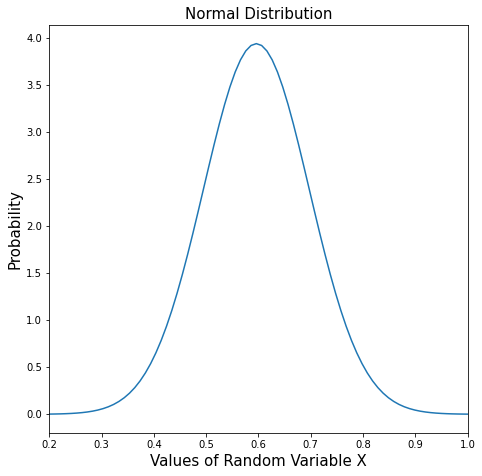

In [ ]:
from scipy import stats
#
# Create a standard normal distribution with mean as 0 and standard deviation as 1
#
mu = 0.595953
std = 0.101261
snd = stats.norm(mu, std)
#
# Generate 100 random values between -5, 5
#
x = np.linspace(0, 1, 100)
#
# Plot the standard normal distribution for different values of random variable
# falling in the range -5, 5
#
plt.figure(figsize=(7.5,7.5))
plt.plot(x, snd.pdf(x))
plt.xlim(0.2, 1)
plt.title('Normal Distribution', fontsize='15')
plt.xlabel('Values of Random Variable X', fontsize='15')
plt.ylabel('Probability', fontsize='15')
plt.show()

In [ ]:
danceCategory = []
for i in df_filtered['danceability']:
    if i <= 0.828000 and i > 0.7119765:
        danceCategory.append('Very High')
    elif i <= 0.7119765 and i >= 0.595953:
        danceCategory.append('High')
    elif i <= 0.595953 and i >= 0.245953:
        danceCategory.append('Medium')
    elif i <= 0.245953 and i >= 0.350000:
        danceCategory.append('low')

df_filtered = df_filtered.assign(danceCategory = danceCategory)

In [ ]:
df_filtered.tail()

,t,foot_x,pronation,braking,impact,contact_time,flight_ratio,strike,power,session_id,user_id,t_start,t_end,duration,foot_y,cadence,speed,track_uri,paused,artist,track,context_uri,context,position,pitches_mean,pitches_std,timbre_mean,timbre_std,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,danceCategory
85452,2020-12-31 09:52:48.990386963,right,-4.6,7.8750,13.4375,396,2.375,5,291,2826E86F-B9A1-44EB-8962-B0CBD54979E4,1865743f-9faa-41e6-8a70-74aa34726884,2020-12-31 08:29:27.754,2020-12-31 10:22:18.245,6770.491056,right,77,2.875000,spotify:track:6o6STE55cbhH4BuM2EJRL9,False,Galantis,Faith (with Dolly Parton) [feat. Mr. Probz],spotify:playlist:37i9dQZF1E38o5h27AIod2,Daily Mix 1,181.888,0.348257,0.298707,11.122952,35.910734,0.547,0.795,8,-3.721,1,0.0489,0.145,0.0,0.111,0.723,118.115,186805,4,Medium
85453,2020-12-31 09:52:49.208564997,left,-9.9,6.5625,11.9375,299,12.875,7,275,2826E86F-B9A1-44EB-8962-B0CBD54979E4,1865743f-9faa-41e6-8a70-74aa34726884,2020-12-31 08:29:27.754,2020-12-31 10:22:18.245,6770.491056,right,77,2.878906,spotify:track:6o6STE55cbhH4BuM2EJRL9,False,Galantis,Faith (with Dolly Parton) [feat. Mr. Probz],spotify:playlist:37i9dQZF1E38o5h27AIod2,Daily Mix 1,181.888,0.348257,0.298707,11.122952,35.910734,0.547,0.795,8,-3.721,1,0.0489,0.145,0.0,0.111,0.723,118.115,186805,4,Medium
85454,2020-12-31 09:52:49.649768829,right,-5.0,7.9375,13.6250,396,2.625,5,341,2826E86F-B9A1-44EB-8962-B0CBD54979E4,1865743f-9faa-41e6-8a70-74aa34726884,2020-12-31 08:29:27.754,2020-12-31 10:22:18.245,6770.491056,right,77,2.878906,spotify:track:6o6STE55cbhH4BuM2EJRL9,False,Galantis,Faith (with Dolly Parton) [feat. Mr. Probz],spotify:playlist:37i9dQZF1E38o5h27AIod2,Daily Mix 1,181.888,0.348257,0.298707,11.122952,35.910734,0.547,0.795,8,-3.721,1,0.0489,0.145,0.0,0.111,0.723,118.115,186805,4,Medium
85455,2020-12-31 09:52:50.018906116,left,-10.1,6.6875,11.9375,300,12.375,7,273,2826E86F-B9A1-44EB-8962-B0CBD54979E4,1865743f-9faa-41e6-8a70-74aa34726884,2020-12-31 08:29:27.754,2020-12-31 10:22:18.245,6770.491056,left,87,3.433594,spotify:track:6o6STE55cbhH4BuM2EJRL9,False,Galantis,Faith (with Dolly Parton) [feat. Mr. Probz],spotify:playlist:37i9dQZF1E38o5h27AIod2,Daily Mix 1,181.888,0.348257,0.298707,11.122952,35.910734,0.547,0.795,8,-3.721,1,0.0489,0.145,0.0,0.111,0.723,118.115,186805,4,Medium
85456,2020-12-31 09:52:50.341722965,right,-5.1,7.8125,14.0000,310,9.625,5,392,2826E86F-B9A1-44EB-8962-B0CBD54979E4,1865743f-9faa-41e6-8a70-74aa34726884,2020-12-31 08:29:27.754,2020-12-31 10:22:18.245,6770.491056,right,77,2.875000,spotify:track:6o6STE55cbhH4BuM2EJRL9,False,Galantis,Faith (with Dolly Parton) [feat. Mr. Probz],spotify:playlist:37i9dQZF1E38o5h27AIod2,Daily Mix 1,181.888,0.348257,0.298707,11.122952,35.910734,0.547,0.795,8,-3.721,1,0.0489,0.145,0.0,0.111,0.723,118.115,186805,4,Medium


In [ ]:
df_filtered['danceCategory'].value_counts()

Medium       15919
High          6825
Very High     4693
Name: danceCategory, dtype: int64

#### **5.1.2.Tracks**

Number each track found in the running session for a clearer view in the self organising maps.


In [ ]:
df_filtered['track'].unique()

array(['Somebody - Fluencee Remix', 'Sapphire - Original Mix',
       'Love To Go', 'Fracture', 'The Bender (with Brando)',
       'Expectations (R3HAB Remix)', 'The Time Is Now', 'Castles',
       'My Best Life (feat. Mike Waters) - Club Mix',
       'My Frequency (feat. RebMoe)', 'I Wanna Know',
       'All Night (feat. Ally Brooke)', 'Choices', 'Figure It Out',
       'Technology', 'Congratulations - Don Diablo VIP Mix',
       'Beat Of My Heart - Deluxe Edit', 'I Still Remember (R3HAB Remix)',
       'Sad Song (feat. TINI) (Alesso Remix)', "Don't Leave Me Now",
       'Problems - Ship Wrek Remix', 'Anywhere',
       'Endless Summer (feat. Penny F.) - Gareth Emery Remix',
       'On Your Mind', 'Sixteen - Don Diablo Remix', 'Cross My Heart',
       'Not So Bad (feat. Emie) - Zonderling Remix',
       'All Of Me (feat. Oliver Nelson)', 'Horizons (feat. Able Faces)',
       'Limbo(Tomillo Remix)', 'Tomorrow (feat. 433)', 'Do It For You',
       'Lift Your Energy', 'Faith (with Dolly P

In [ ]:
#Not being used but might prove usefull in the future
#
#https://stackoverflow.com/questions/60081686/python-how-to-map-numbers-to-unique-items-enumerate-unique-objects-in-a-colum
#
#mapping = {item:i for i, item in enumerate(df_filtered["track"].unique())}
#df_filtered["trackCodes"] = df_filtered["track"].apply(lambda x: mapping[x])
#df_filtered[['track', 'trackCodes']]

In [ ]:
track_codes = {
    'Somebody - Fluencee Remix'  : '1', 
    'Hide Away (feat. Envy Monroe)' : '2',
    'Fire (with Elderbrook)' : '3', 
    'Liquid Spirit - Claptone Remix' : '4',
    'Sapphire - Original Mix' : '5', 
    'Love To Go' : '6', 
    'Fracture' : '7',
    'In Your Eyes (feat. Alida) - KREAM Remix' : '8', 
    'Straight To You' : '9',
    'The Business' : '10', 
    'Ritual' : '11', 
    'Hold On (feat. Michel Zitron)' : '12',
    'Say My Name' : '13', 
    'Congratulations' : '14', 
    'Perfect (feat. Haris)' : '15',
    'Lose You' : '16', 
    'The Bender (with Brando)' : '17',
    'Used To Love (with Dean Lewis) - SWACQ Remix' : '18',
    'Expectations (R3HAB Remix)' : '19', 
    'No Lie - HUGEL Remix' : '20',
    'The Time Is Now' : '21', 
    'Castles' : '22', 
    'Finding Our Way' : '23',
    'Gasoline (feat. Laura White)' : '24',
    'Made In France (with Tchami & Malaa, feat. Mercer) - Wax Motif Remix' : '25',
    'My Best Life (feat. Mike Waters) - Club Mix' : '26',
    'Feel Right Now (feat. Nonô)' : '27', 
    'Cry (with John Martin)' : '28',
    'Piece Of Your Heart' : '29', 
    'My Frequency (feat. RebMoe)' : '30',
    'I Wanna Know' : '31', 
    'Bla Bla Bla' : '32', 
    'Bad Habit' : '33',
    'All Night (feat. Ally Brooke)' : '34', 
    'Nothing' : '35', 
    'Choices' : '36',
    'Automatic (feat. Fiora) - The Aston Shuffle Remix' : '37',
    'Figure It Out' : '38', 
    "I'll Feel The Same" : '39', 
    'Need You Now' : '40',
    'One More Night' : '41', 
    'Endless Summer' : '42', 
    'Technology' : '43',
    "Don't Leave Me Now" : '44', 
    'Lie To Me (feat. Tinashe & Runtown)' : '45',
    'Home' : '46', 
    'Congratulations - Don Diablo VIP Mix' : '47', 
    'Recognise' : '48',
    'High On Life (feat. Bonn)' : '49', 
    'Nothing Really Matters' : '50',
    'Thousand Faces' : '51',
    'Drown (feat. Clinton Kane) - Nicky Romero Remix' : '52', 
    'Never Change' : '53',
    'The Same Way' : '54', 
    'Alkantara' : '55', 
    'Turn Me On (feat. Vula)' : '56',
    'Sun Is Shining' : '57', 
    'Beat Of My Heart - Deluxe Edit' : '58',
    'When You Leave - Breathe Carolina Remix' : '59',
    'Born To Love (feat. SHELLS)' : '97', 
    'I Still Remember (R3HAB Remix)' : '60',
    'Intuition (Dance Valley 2019 Anthem)' : '61', 
    'Lose Control' : '62',
    'Alone, Pt. II' : '63', 
    'I Need You To Know' : '64', 
    'SICKO - Felix Jaehn Remix' : '65',
    'Sad Song (feat. TINI) (Alesso Remix)' : '66', 
    "Comin' To Getcha" : '67',
    'Before U (feat. AlunaGeorge) - Reblok Remix' : '68',
    'Problems - Ship Wrek Remix' : '69', 
    'Anywhere' : '70',
    'Endless Summer (feat. Penny F.) - Gareth Emery Remix' : '71',
    'On Your Mind' : '72', 
    'Sixteen - Don Diablo Remix' : '73', 
    'Cross My Heart' : '74',
    'Not So Bad (feat. Emie) - Zonderling Remix' : '75',
    'All Of Me (feat. Oliver Nelson)' : '76', 
    'Horizons (feat. Able Faces)' : '77',
    'Limbo(Tomillo Remix)' : '78', 
    'Tomorrow (feat. 433)' : '79', 
    'Do It For You' : '80',
    'Lift Your Energy' : '81', 
    'Faith (with Dolly Parton) [feat. Mr. Probz]' : '82',
    'One Million' : '83', 
    'Still Right Here' : '84', 
    'Therapy' : '85', 
    'Wait For You' : '86',
    'Younger - Punctual Remix' : '87', 
    'Take Me Back' : '88',
    '1234 (feat. MC Ambush)' : '89', 
    'Wake Up' : '90', 
    'Another Side' : '91',
    'Voices (feat. TZAR)' : '92', 
    'Tragic (feat. Amber Van Day)' : '93',
    '2 Hearts (feat. Gia Koka)' : '94', 
    'Endlessly' : '95',
    'Drown (feat. Clinton Kane)' : '96'}

In [ ]:
df_filtered.shape

(27437, 42)

In [ ]:
print(27437*5)

137185


### **5.2.New Data**

#### **5.2.1.Danceability**

In [ ]:
fig = px.box(df_filtered_new_data, y = 'danceability')
fig.show()

##### **5.2.1.1.Normal Distribution**

In [ ]:
df_filtered_new_data[['danceability']].describe()

,danceability
count,17.000000
mean,0.661588
std,0.139294
min,0.366000
25%,0.584000
50%,0.704000
75%,0.751000
max,0.877000


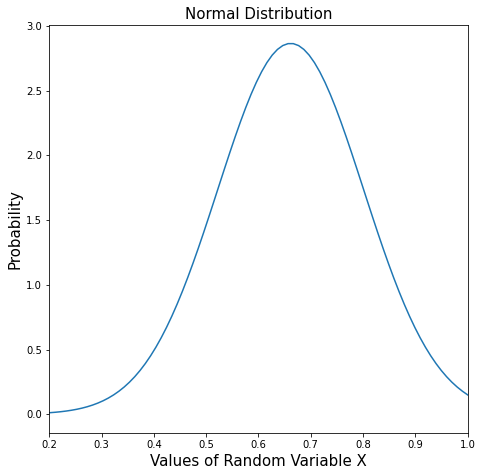

In [ ]:
#
# Create a standard normal distribution with mean as 0 and standard deviation as 1
#
mu = 0.661588
std = 0.139294
snd = stats.norm(mu, std)
#
# Generate 100 random values between -5, 5
#
x = np.linspace(0, 1, 100)
#
# Plot the standard normal distribution for different values of random variable
# falling in the range -5, 5
#
plt.figure(figsize=(7.5,7.5))
plt.plot(x, snd.pdf(x))
plt.xlim(0.2, 1)
plt.title('Normal Distribution', fontsize='15')
plt.xlabel('Values of Random Variable X', fontsize='15')
plt.ylabel('Probability', fontsize='15')
plt.show()

In [ ]:
danceCategory = []
for i in df_filtered_new_data['danceability']:
    if i <= 0.877 and i > 0.752:
        danceCategory.append('Very High')
    elif i <= 0.752 and i >= 0.704:
        danceCategory.append('High')
    elif i <= 0.704 and i >= 0.58125:
        danceCategory.append('Medium')
    elif i <= 0.58125 and i >= 0.366:
        danceCategory.append('low')

df_filtered_new_data = df_filtered_new_data.assign(danceCategory = danceCategory)

#### **5.2.2.Tracks**

Number each track found in the running session for a clearer view in the self organising maps.

In [ ]:
df_filtered_new_data['track_uri'].unique()

array(['spotify:track:0LlleCJVkI3axaEZvksrXd',
       'spotify:track:0qbM7dVGfMI3Pw4QuXYmuM',
       'spotify:track:5HFPK8mcO6BGPZNeZPZI5L',
       'spotify:track:6wp5tGVNQYpKJPo1s3WUEY',
       'spotify:track:3aeDiM8FSBy3ka3xjuHCAP',
       'spotify:track:14d79QOV2pvJHH9vlUfZwJ',
       'spotify:track:5ZzILZizRnw3uCFZh8lTBf',
       'spotify:track:45vQQXKfA4edHqKV5roP3M',
       'spotify:track:4rJWwoYebrzzq6zJmqsRTs',
       'spotify:track:6f3Slt0GbA2bPZlz0aIFXN',
       'spotify:track:3M9Apu4OZfylLTFKvgEtKa',
       'spotify:track:22zxLxXlXrBIm7XaazHNrg',
       'spotify:track:3GYlQmwfBDo7imFyGPhrl7',
       'spotify:track:1FG7QNYVJz1x50D8AzOVQt',
       'spotify:track:30cW9fD87IgbYFl8o0lUze',
       'spotify:track:7sFk2PA3NsrrSsGa4CM3rs',
       'spotify:track:3INNLgKkHn8HOodDulCd7x'], dtype=object)

In [ ]:
track_codes_new_data = {
    'spotify:track:0LlleCJVkI3axaEZvksrXd' : '1',
    'spotify:track:0qbM7dVGfMI3Pw4QuXYmuM' : '2',
    'spotify:track:5HFPK8mcO6BGPZNeZPZI5L' : '3',
    'spotify:track:6wp5tGVNQYpKJPo1s3WUEY' : '4',
    'spotify:track:3aeDiM8FSBy3ka3xjuHCAP' : '5',
    'spotify:track:14d79QOV2pvJHH9vlUfZwJ' : '6',
    'spotify:track:5ZzILZizRnw3uCFZh8lTBf' : '7',
    'spotify:track:45vQQXKfA4edHqKV5roP3M' : '8',
    'spotify:track:4rJWwoYebrzzq6zJmqsRTs' : '9',
    'spotify:track:6f3Slt0GbA2bPZlz0aIFXN' : '10',
    'spotify:track:3M9Apu4OZfylLTFKvgEtKa' : '11',
    'spotify:track:22zxLxXlXrBIm7XaazHNrg' : '12',
    'spotify:track:3GYlQmwfBDo7imFyGPhrl7' : '13',
    'spotify:track:1FG7QNYVJz1x50D8AzOVQt' : '14',
    'spotify:track:30cW9fD87IgbYFl8o0lUze' : '15',
    'spotify:track:7sFk2PA3NsrrSsGa4CM3rs' : '16',
    'spotify:track:3INNLgKkHn8HOodDulCd7x' : '17'}

## **6.Self Organising Maps**

The goal of the technique is to reduce dimensions and detect features. The maps help to visualize high-dimensional data. It represents the multidimensional data in a two- dimensional space using the self-organizing neural networks.

### **6.1.Old Data**

In [ ]:
df_filtered.columns

Index(['t', 'foot_x', 'pronation', 'braking', 'impact', 'contact_time',
       'flight_ratio', 'strike', 'power', 'session_id', 'user_id', 't_start',
       't_end', 'duration', 'foot_y', 'cadence', 'speed', 'track_uri',
       'paused', 'artist', 'track', 'context_uri', 'context', 'position',
       'pitches_mean', 'pitches_std', 'timbre_mean', 'timbre_std',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'danceCategory'],
      dtype='object')

In [ ]:
category_color = {'Very High': 'darkgreen', 'High': 'limegreen', 'Medium': 'darkorange', 'low': 'crimson'}
colors_dict = {c: category_color[dm] for c, dm in zip(df_filtered.track, df_filtered.danceCategory)}    
feature_names = ['pronation','braking','impact','contact_time','power', 'strike'] 

In [ ]:
#Rows * 5 is the number of epoch needed in the code below
df_filtered.shape

(27437, 42)

In [ ]:
X = df_filtered[feature_names].values
X = scale(X)
size = 15
som = MiniSom(size, size, len(X[0]), neighborhood_function = 'gaussian', sigma = 1.5, random_seed = 1)
som.pca_weights_init(X)
#change the epoch to a higher value. The best is to put in 5 times the shape of the rows. 94930 * 5
som.train_random(X, 137185, verbose = True)

 [ 137185 / 137185 ] 100% - 0:00:00 left 
 quantization error: 0.692162778447689


#### **6.1.1.Distance Map**

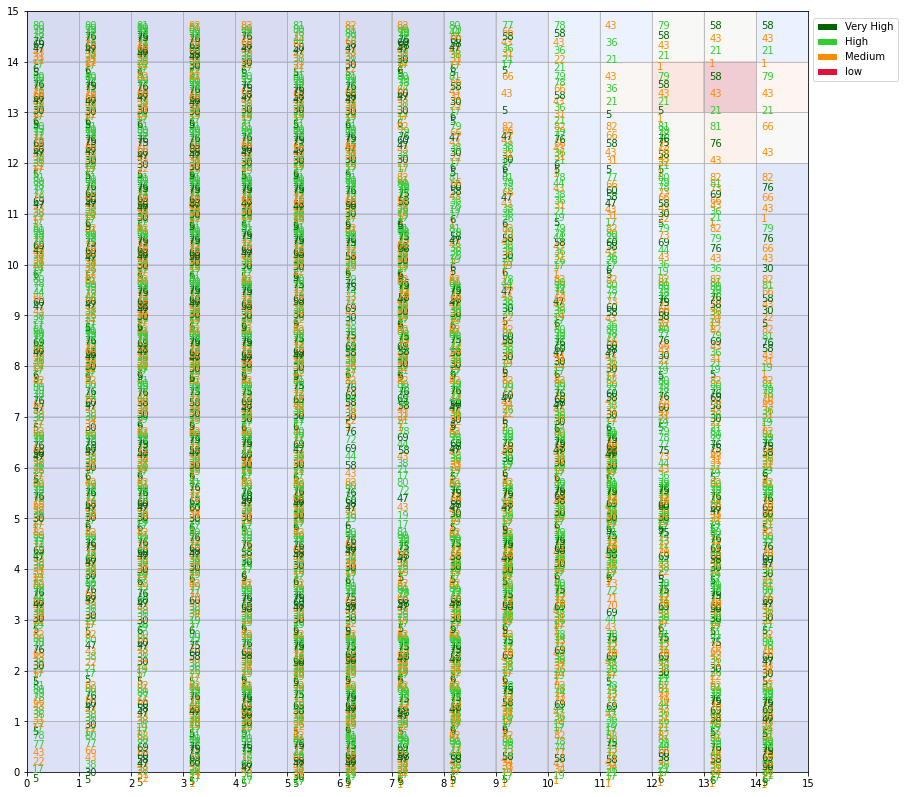

In [ ]:
def shorten_track(c):
    if len(c) > 6:
        return track_codes[c]
    else:
        return c

track_map = som.labels_map(X, df_filtered.track)
    
plt.figure(figsize = (14, 14))
for p, tracks in track_map.items():
    tracks = list(tracks)
    x = p[0] + .1
    y = p[1] - .3
    for i, c in enumerate(tracks):
        off_set = (i + 1)/len(tracks) - 0.05
        plt.text(x, y + off_set, shorten_track(c), color = colors_dict[c], fontsize = 10)
plt.pcolor(som.distance_map().T, cmap='coolwarm', alpha = .2)
plt.xticks(np.arange(size + 1))
plt.yticks(np.arange(size + 1))
plt.grid()

legend_elements = [Patch(facecolor = clr, edgecolor = 'w', label = l) for l, clr in category_color.items()]
plt.legend(handles = legend_elements, loc = 'center left', bbox_to_anchor = (1, .95))
plt.show()

#### **6.1.2.Feature Planes**

In this part the map is created for each feature used that reflects the magnitude of the weights associated to it for each neuron.

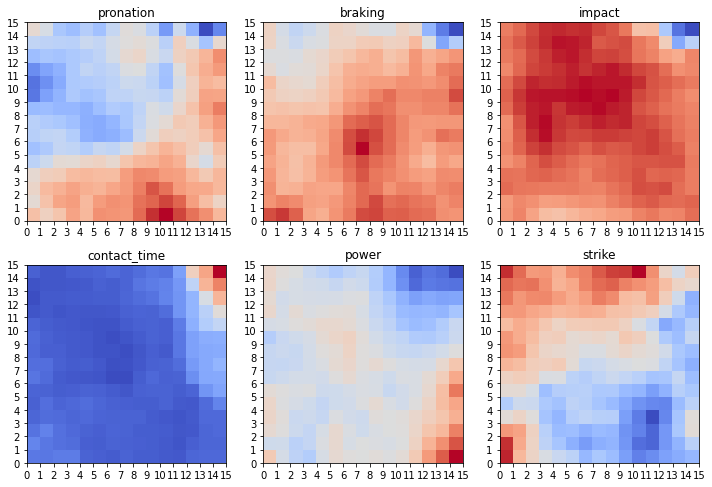

In [ ]:
W = som.get_weights()
plt.figure(figsize=(10, 10))
for i, f in enumerate(feature_names):
    plt.subplot(3, 3, i+1)
    plt.title(f)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
    plt.xticks(np.arange(size+1))
    plt.yticks(np.arange(size+1))
plt.tight_layout()
plt.show()

##### **6.1.2.1.Most Relevant Feature Plane**

In this map each neuron gets associated to the feature with the maximum weight. This splits up the map into multiple regions where the features have high values.

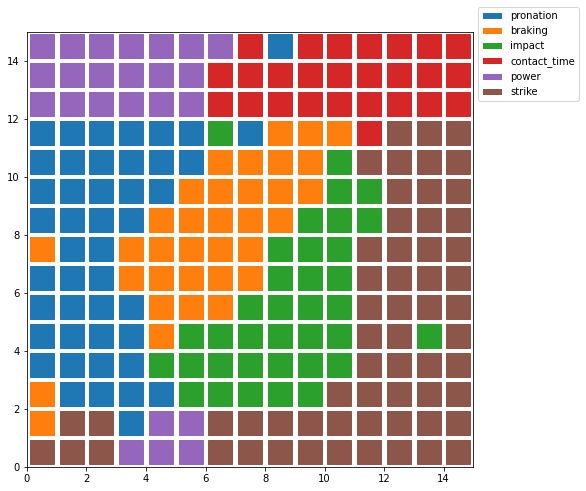

In [ ]:
Z = np.zeros((size, size))
plt.figure(figsize=(8, 8))
for i in np.arange(som._weights.shape[0]):
    for j in np.arange(som._weights.shape[1]):
        feature = np.argmax(W[i, j , :])
        plt.plot([j+.5], [i+.5], 'o', color='C'+str(feature),
                 marker='s', markersize=24)

legend_elements = [Patch(facecolor='C'+str(i),
                         edgecolor='w',
                         label=f) for i, f in enumerate(feature_names)]

plt.legend(handles=legend_elements,
           loc='center left',
           bbox_to_anchor=(1, .95))
        
plt.xlim([0, size])
plt.ylim([0, size])
plt.show()

### **6.2.New Data**

In [ ]:
df_filtered_new_data.columns

Index(['Unnamed: 0', 'session_id', 'track_uri', 'pronation_left_mean',
       'pronation_left_std', 'pronation_left_median', 'pronation_left_iqr',
       'pronation_left_rmse', 'pronation_left_mae', 'pronation_left_hurst',
       ...
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature',
       'pitches_mean', 'pitches_std', 'timbre_mean', 'timbre_std',
       'danceCategory'],
      dtype='object', length=321)

In [ ]:
category_color = {'Very High': 'darkgreen', 'High': 'limegreen', 'Medium': 'darkorange', 'low': 'crimson'}
colors_dict = {c: category_color[dm] for c, dm in zip(df_filtered_new_data.track_uri, df_filtered_new_data.danceCategory)}    
feature_names_new_data = ['pronation_sa_mean','braking_sa_mean','impact_sa_mean','contact_time_sa_mean','power_sa_mean','strike_sa_mean'] 

In [ ]:
#Rows * 5 is the number of epoch needed in the code below
df_filtered_new_data.shape

(17, 321)

In [ ]:
X = df_filtered_new_data[feature_names_new_data].values
X = scale(X)
size = 15
som = MiniSom(size, size, len(X[0]), neighborhood_function = 'gaussian', sigma = 1.5, random_seed = 1)
som.pca_weights_init(X)
#change the epoch to a higher value. The best is to put in 5 times the shape of the rows. 94930 * 5
som.train_random(X, 1585, verbose = True)

 [ 1585 / 1585 ] 100% - 0:00:00 left 
 quantization error: 2.992903635482559e-07


/usr/local/lib/python3.7/dist-packages/minisom.py:486: RuntimeWarning:

invalid value encountered in sqrt



#### **6.2.1.Distance Map**

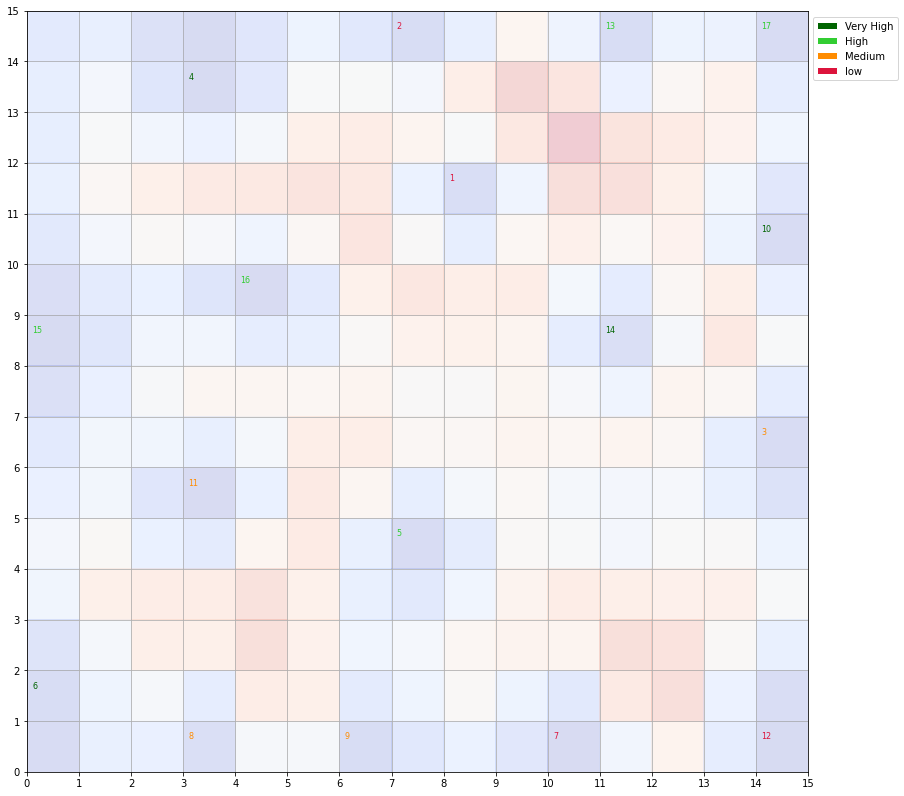

In [ ]:
def shorten_track(c):
    if len(c) > 6:
        return track_codes_new_data[c]
    else:
        return c

track_map = som.labels_map(X, df_filtered_new_data.track_uri)
    
plt.figure(figsize = (14, 14))
for p, tracks in track_map.items():
    tracks = list(tracks)
    x = p[0] + .1
    y = p[1] - .3
    for i, c in enumerate(tracks):
        off_set = (i + 1)/len(tracks) - 0.05
        plt.text(x, y + off_set, shorten_track(c), color = colors_dict[c], fontsize = 8)
plt.pcolor(som.distance_map().T, cmap='coolwarm', alpha = .2)
plt.xticks(np.arange(size + 1))
plt.yticks(np.arange(size + 1))
plt.grid()

legend_elements = [Patch(facecolor = clr, edgecolor = 'w', label = l) for l, clr in category_color.items()]
plt.legend(handles = legend_elements, loc = 'center left', bbox_to_anchor = (1, .95))
plt.show()

#### **6.2.2.Feature Planes**

In this part the map is created for each feature used that reflects the magnitude of the weights associated to it for each neuron.

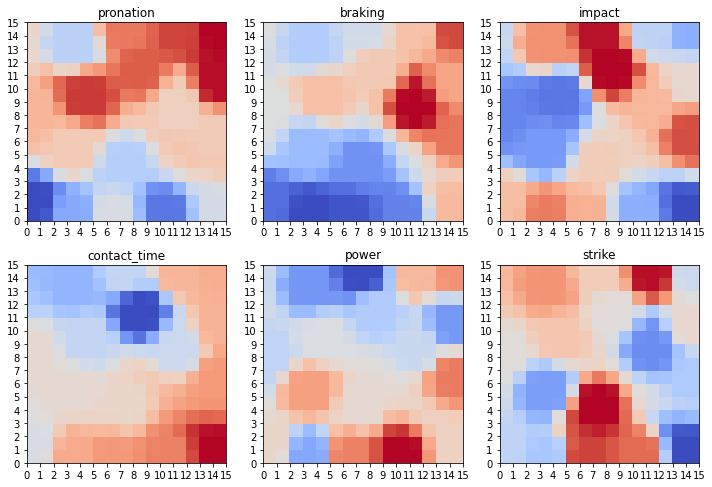

In [ ]:
W = som.get_weights()
plt.figure(figsize=(10, 10))
for i, f in enumerate(feature_names):
    plt.subplot(3, 3, i+1)
    plt.title(f)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
    plt.xticks(np.arange(size+1))
    plt.yticks(np.arange(size+1))
plt.tight_layout()
plt.show()

##### **6.2.2.1.Most Relevant Feature Plane**

In this map each neuron gets associated to the feature with the maximum weight. This splits up the map into multiple regions where the features have high values.

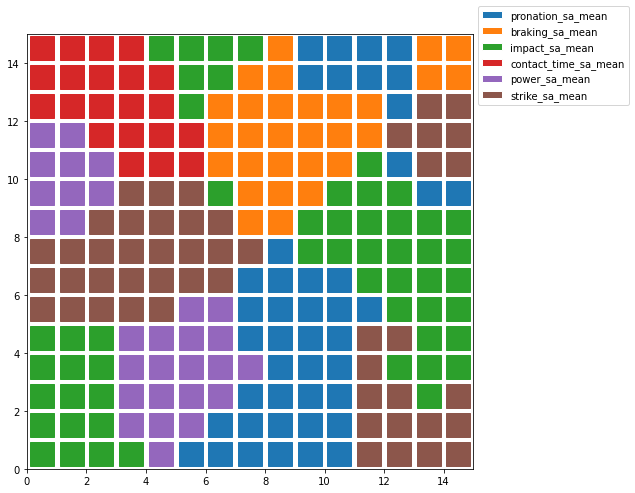

In [ ]:
Z = np.zeros((size, size))
plt.figure(figsize=(8, 8))
for i in np.arange(som._weights.shape[0]):
    for j in np.arange(som._weights.shape[1]):
        feature = np.argmax(W[i, j , :])
        plt.plot([j+.5], [i+.5], 'o', color='C'+str(feature),
                 marker='s', markersize=24)

legend_elements = [Patch(facecolor='C'+str(i),
                         edgecolor='w',
                         label=f) for i, f in enumerate(feature_names_new_data)]

plt.legend(handles=legend_elements,
           loc='center left',
           bbox_to_anchor=(1, .95))
        
plt.xlim([0, size])
plt.ylim([0, size])
plt.show()